In [1]:
import sys
sys.path.append('../code')
import FOT

import math
import numpy as np
from scipy.spatial.distance import cdist
import random
import ot

import matplotlib.pyplot as plt
import ot.plot

In [2]:
def plot_transport_heatmap(T, title="Transport plan T (rows: X_i, cols: Y_j)", 
                           xlabel = 'target index j', 
                           ylabel = 'source index i',
                           legend_label = 'mass T[i,j]'):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(T, aspect='auto')  # 행: X_i, 열: Y_j
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(legend_label)
    plt.tight_layout()
    plt.show()

# Isometry mapping

commutator norm (P*):    0.4985153547162857
commutator norm (Prev):  2.9077544976373364


Text(0.5, 1.0, 'Source and target distributions')

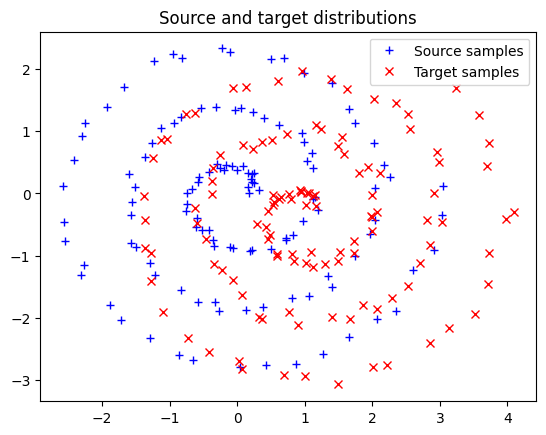

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

# 1) 데이터: 불균일 스파이럴 (표본 간격 랜덤)
def spiral(t, a=0.2, b=0.15):
    r = a + b*t
    return np.stack([r*np.cos(t), r*np.sin(t)], axis=1)

rng = np.random.default_rng(0)
n = 120
t_sorted = np.linspace(0, 6*np.pi, n)
# 불균일 표본: 약간의 jitter로 순서 간격을 깨서 대칭성 제거
tX = t_sorted + rng.normal(0, 0.03, size=n)

xs = spiral(tX) + 0.05*np.random.randn(n,2)  # X points (2D)

# 2) 등거리 변환: 회전 + 평행이동
phi = 0.7
R = np.array([[np.cos(phi), -np.sin(phi)],
              [np.sin(phi),  np.cos(phi)]])
shift = np.array([1.0, -0.3])
xt = xs @ R.T + shift + 0.05*np.random.randn(n,2)  # Y = rigid transform of X

# 3) 커널: 2D 좌표 기반 RBF (distance similarity; 감소형)
def rbf_kernel(X, h=None):
    D2 = cdist(X, X, 'sqeuclidean')
    if h is None:
        # 평균 5-NN 거리의 중앙값을 스케일로
        D = np.sqrt(D2)
        k = 5
        knei = np.partition(D, k, axis=1)[:, k]
        h = np.median(knei) + 1e-8
    K = np.exp(-D2 / (h**2))
    # 정규화(선택): 대각합 스케일 차이 완화
    d = K.sum(1, keepdims=True)
    K = K / np.sqrt(d @ d.T)
    return K

KX = rbf_kernel(xs)
KY = rbf_kernel(xt)

# 4) 확인: 정답 퍼뮤만 커뮤테이터 ~0, 역순은 큼
# 정답 퍼뮤는 생성 인덱스 그대로 (P* = I)
def comm_norm(KA, KB, P):
    # || KA P - P KB ||_F
    return np.linalg.norm(KA @ P - P @ KB, 'fro')

P_star = np.eye(n)                 # 정답
P_rev  = np.fliplr(np.eye(n))      # 역순(가짜)

print("commutator norm (P*):   ", comm_norm(KX, KY, P_star))
print("commutator norm (Prev): ", comm_norm(KX, KY, P_rev))

# 5) 이제 너의 QP에서 \hat D_X^\kappa=KX, \hat D_Y^\kappa=KY, alpha=1 로 두고 FW 실행
#    -> \hat{\pi}는 단일 대각선(정답)에 질량이 모여야 함.
# model = FOT.ConvexFusedTransport(alpha=1, kappa=lambda t: np.exp(-t**2),
#                                  metric='euclidean', fw_max_iter=200, ...)
# model.fit(X=None, Y=None, FX=None, FY=None, KX=KX, KY=KY, return_hard_assignment=True)

plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
plt.legend(loc=0)
plt.title("Source and target distributions")

In [4]:
model = FOT.ConvexFusedTransport(
    alpha=1,
    # kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    metric='euclidean',
    fw_max_iter=100,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd'
).fit(X=tX.reshape(-1,1),Y=tX.reshape(-1,1),FX=xs,FY=xt, return_hard_assignment=True)

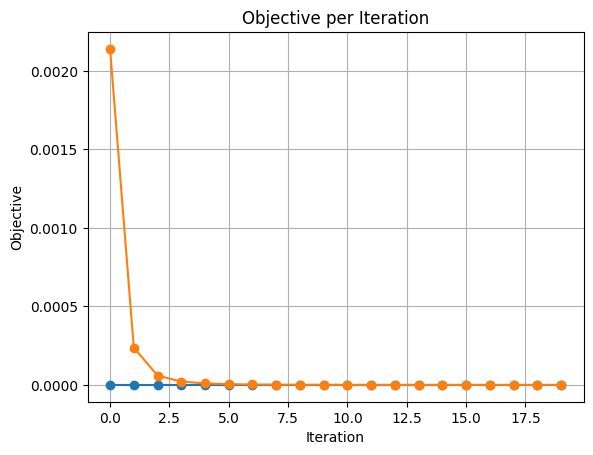

In [5]:
plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

In [6]:
# plt.plot(range(len(model.gap_history_)), model.gap_history_, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('FW Gap')
# plt.title('FW Gap per Iteration')
# plt.grid(True)
# plt.show()

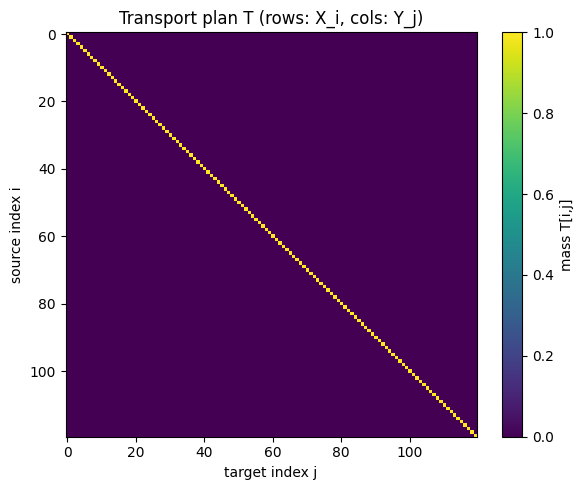

In [7]:
plot_transport_heatmap(model.P_)

In [8]:
M = ot.dist(xs,xt, metric='sqeuclidean')
C1 = ot.dist(tX.reshape(-1,1),tX.reshape(-1,1), metric='euclidean')
C2 = C1 = ot.dist(tX.reshape(-1,1),tX.reshape(-1,1), metric='euclidean')

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
alpha = 1
T_FGW = ot.gromov.fused_gromov_wasserstein(M, C1, C2, a, b, alpha=alpha, loss_fun='square_loss')

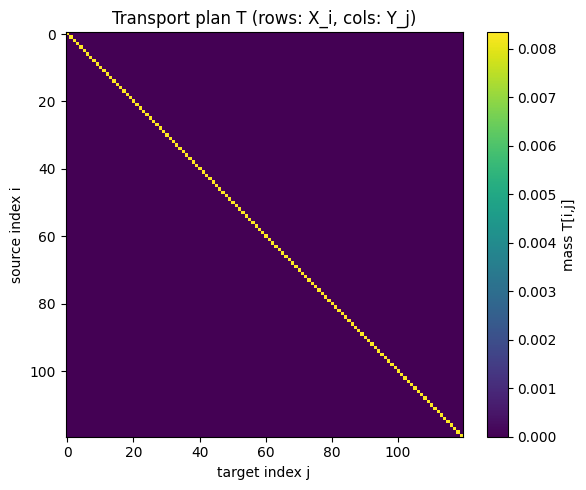

In [9]:
plot_transport_heatmap(T_FGW)

# Structured objects

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# -------------------------------
# Utils: data generators
# -------------------------------
def sample_dc_sbm(n, B, pin, pout, similar_pair=(0,1), delta=0.0, rng=None):
    """
    Degree-corrected SBM.
    Blocks 'similar_pair' have nearly the same internal structure when delta≈0.
    pin: scalar or list length B (within-block base probability)
    pout: scalar (across-block probability)
    """
    if rng is None: rng = np.random.default_rng()
    # balanced sizes
    sizes = [n // B] * B
    for i in range(n - sum(sizes)): sizes[i] += 1
    z = np.repeat(np.arange(B), sizes)                 # block labels (0..B-1)

    # per-block p_in
    if np.isscalar(pin): pin_b = np.array([pin]*B, dtype=float)
    else:               pin_b = np.array(pin, dtype=float)

    # enforce similarity between a,b
    a, b = similar_pair
    base = (pin_b[a] + pin_b[b]) / 2.0
    pin_b[a] = base + delta/2.0
    pin_b[b] = base - delta/2.0

    # node degree parameters (break symmetry within block)
    theta = rng.gamma(shape=2.0, scale=0.7, size=n)
    theta = theta / np.mean(theta)

    A = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            basep = pin_b[z[i]] if z[i] == z[j] else pout
            pij = basep * theta[i] * theta[j]
            if pij > 0.9: pij = 0.9
            A[i, j] = A[j, i] = rng.random() < pij
    np.fill_diagonal(A, 0)
    return A, z, theta, pin_b

import numpy as np

def blockwise_permutation(z, block_perm=None, rng=None,
                          shuffle_within_source=True,
                          shuffle_within_target=True):
    """
    z: (n,) block labels (0..B-1)
    block_perm: dict, old_block -> new_block (예: {0:2,1:0,2:1}); None이면 identity
    shuffle_within_source: True면 소스 블록 내에서도 순서를 무작위 셔플
    shuffle_within_target: True면 타깃 블록 내 후보도 무작위 셔플
    return: perm (길이 n) so that new_order = old[perm]
    """
    if rng is None:
        rng = np.random.default_rng()

    n = len(z)
    uniq = np.unique(z)
    if block_perm is None:
        block_perm = {b: b for b in uniq}

    # (선택) 블록별 인덱스 사전
    idx_by_block = {b: np.where(z == b)[0] for b in uniq}
    if shuffle_within_source:
        for b in uniq:
            idx_by_block[b] = rng.permutation(idx_by_block[b])

    perm = np.empty(n, dtype=int)

    for b in uniq:
        src = idx_by_block[b]
        dst_block = block_perm[b]
        dst = np.where(z == dst_block)[0]
        if shuffle_within_target:
            dst = rng.permutation(dst)
        # 크기가 같다고 가정(SBM 균형 또는 완전 퍼뮤일 때)
        assert len(src) == len(dst), "block sizes must match for a pure permutation"
        perm[src] = dst
    return perm

def perm_matrix(perm):
    n = len(perm)
    P = np.zeros((n, n), dtype=float)
    P[np.arange(n), perm] = 1.0
    return P

def heat_kernel_from_adj(A, t=1.0, normalize=True, order=2):
    L = laplacian(csr_matrix(A), normed=False).toarray()
    I = np.eye(A.shape[0])
    if order == 2:
        K = I - t*L + 0.5*(t**2) * (L @ L)
    else:
        K = I - t*L
    if normalize:
        d = K.sum(1, keepdims=True); d = np.clip(d, 1e-8, None)
        K = K / np.sqrt(d @ d.T)
    return K

def make_block_features(z, d=6, margin=2.0, noise=0.5, rng=None):
    """Block-wise Gaussian features: f_i ~ N(mu_{z_i}, noise^2 I)."""
    if rng is None: rng = np.random.default_rng()
    B = z.max() + 1
    mu = np.zeros((B, d))
    for b in range(B): mu[b, b % d] = margin
    FX = mu[z] + noise * rng.standard_normal((len(z), d))
    return FX, mu

In [329]:
# rng = np.random.default_rng(123)
rng = None

# Graph
n = 150
B = 3
pin = 0.13
pout = 0.02
similar_pair = (0, 1)   # blocks 0 and 1 structurally similar
delta = 0.1             # == 0 → 거의 동일 구조 (hard case)
t_heat = 1            # heat-kernel scale

A_X, z, theta, pin_b = sample_dc_sbm(n, B, pin, pout, similar_pair, delta, rng)
perm = blockwise_permutation(z, block_perm={0:2,1:0,2:1}, rng=rng,
                             shuffle_within_source=True,
                             shuffle_within_target=True)
P_true = perm_matrix(perm)
A_Y = P_true.T @ A_X @ P_true    # Y: within-block permutation only

# Features (block-level informative, intra-block ambiguous)
FX, mu = make_block_features(z, d=3, margin=0.2, noise=0.01, rng=rng)
FY = P_true.T @ FX
small_perturbations, mu = make_block_features(z, d=3, margin=0.0, noise=0.1, rng=rng)
FY = FY + small_perturbations

# Structure kernels
KX = heat_kernel_from_adj(A_X, t=t_heat, normalize=True, order=2)
KY = heat_kernel_from_adj(A_Y, t=t_heat, normalize=True, order=2)

# Feature cost (squared Euclidean between features)
C_f = cdist(FX, FY, metric="sqeuclidean")

In [339]:
model = FOT.ConvexFusedTransport(
    alpha=0.9999,
    # kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    metric='euclidean',
    fw_max_iter=100,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd',
    pre_Cf=C_f,
    pre_DX=KX,
    pre_DY=KY
).fit(X=np.array(z).reshape(-1,1),Y=np.array(z).reshape(-1,1),FX=None,FY=None,return_hard_assignment=True)

print(np.array(model.obj_history_).mean(axis=0))

[8.13464065e-06 1.05875348e-05]


In [340]:
node_acc  = np.mean(np.argmax(model.P_, axis=1) == np.argmax(P_true, axis=1))
block_acc = np.mean(z[np.argmax(model.P_, axis=1)] == z[np.argmax(P_true, axis=1)])

print('Node Accuracy:',node_acc)
print('Block Accuracy:',block_acc)

Node Accuracy: 0.0
Block Accuracy: 0.9333333333333333


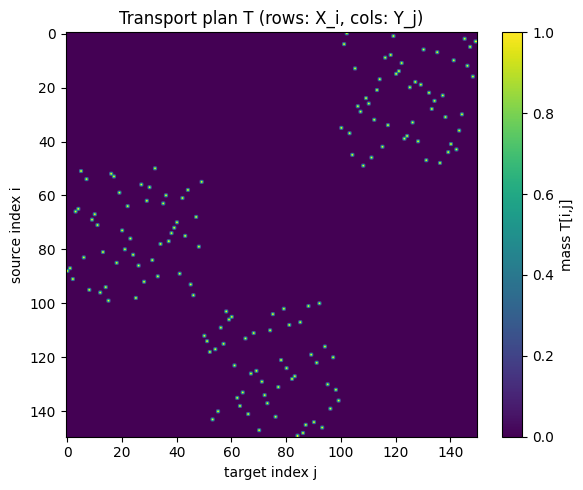

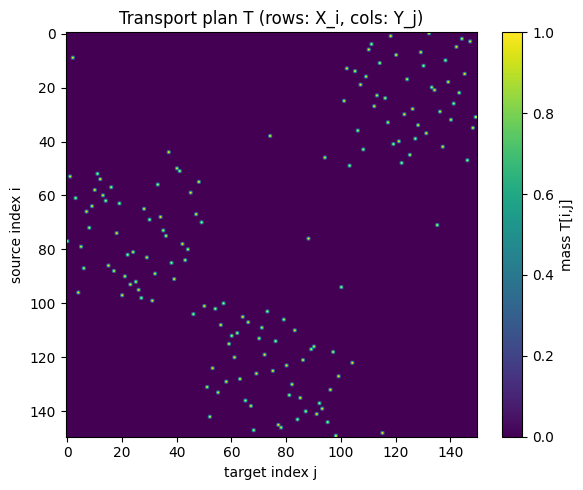

In [341]:
plot_transport_heatmap(P_true)
plot_transport_heatmap(model.P_)

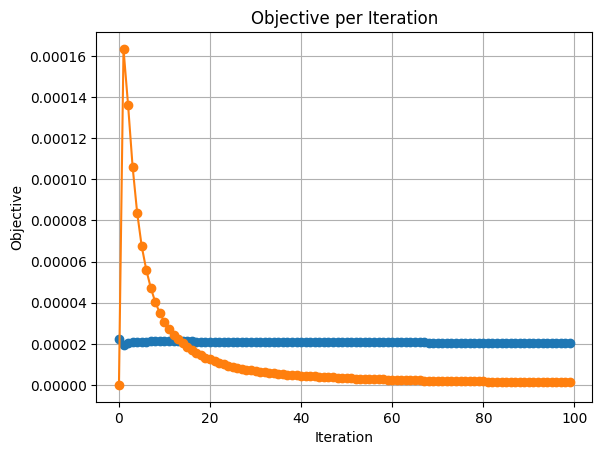

In [301]:
plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

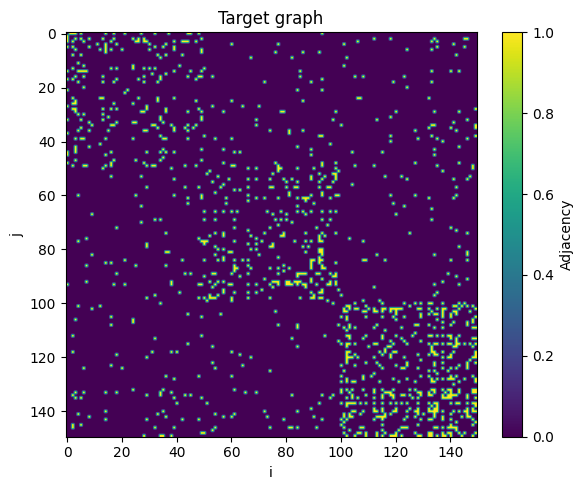

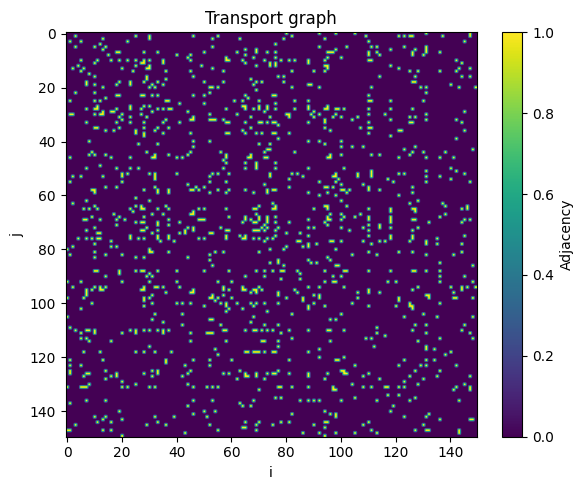

In [302]:
plot_transport_heatmap(A_Y,
                      title = 'Target graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

plot_transport_heatmap(model.P_.T @ A_X @ model.P_,
                      title = 'Transport graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

In [303]:
a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
alpha = 1

T_FGW = ot.gromov.fused_gromov_wasserstein(C_f, KX, KY, a, b, alpha=alpha, loss_fun='square_loss')

In [304]:
node_acc  = np.mean(np.argmax(T_FGW, axis=1) == np.argmax(P_true, axis=1))
block_acc = np.mean(z[np.argmax(T_FGW, axis=1)] == z[np.argmax(P_true, axis=1)])

print('Node Accuracy:',node_acc)
print('Block Accuracy:',block_acc)

Node Accuracy: 0.02
Block Accuracy: 0.35333333333333333


In [107]:
model.obj_history_

[[0.0004825670352956761, 2.7020501092569356e-37],
 [0.00016087381719395076, 1.439730276203973e-07],
 [8.050297713745681e-05, 8.832342529440046e-06],
 [4.8860674601413925e-05, 3.952097506151809e-05],
 [3.36352936638472e-05, 4.319682209273744e-05],
 [2.498033574309957e-05, 4.0490342396920916e-05],
 [1.9471216278902987e-05, 3.5707773381905665e-05],
 [1.587842268647638e-05, 3.151851880889711e-05],
 [1.340720087752739e-05, 2.7304965456034127e-05],
 [1.165238969537527e-05, 2.3619294907756546e-05],
 [1.0301563968508997e-05, 2.052959910935828e-05],
 [9.275512070028484e-06, 1.8324868220166964e-05],
 [8.482282160605085e-06, 1.6495006780319003e-05],
 [7.809831762269678e-06, 1.4820940726005185e-05],
 [7.2893641716740584e-06, 1.3209677325307191e-05],
 [6.884313515824547e-06, 1.195720373030839e-05],
 [6.534242688606104e-06, 1.0861507131880768e-05],
 [6.275865220316431e-06, 9.952071179763388e-06],
 [6.030598246405561e-06, 9.253980360404049e-06],
 [5.811192018507205e-06, 8.576882267490784e-06],
 [5.59